In [ ]:
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_docling import DoclingLoader
from langchain_openai import AzureChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END, START, StateGraph
from langgraph.types import Send
from pydantic_core import core_schema
from typing import Annotated, Any, Dict, List, Literal, TypedDict

import getpass
import html
import json
import logging
import mimetypes
import operator
import os
import re
import time
import unicodedata

In [ ]:
# Load environment variables from .env file
load_dotenv()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("AZURE_OPENAI_ENDPOINT")
_set_env("AZURE_OPENAI_API_KEY")
_set_env("AZURE_OPENAI_DEPLOYMENT_NAME")
_set_env("AZURE_OPENAI_MODEL_NAME")
_set_env("AZURE_OPENAI_API_VERSION")
_set_env("REPROMPTING")
_set_env("MAX_PROMPTS")
_set_env("CHUNK_SIZE")
_set_env("CHUNK_OVERLAP")

REPROMPTING = os.environ["REPROMPTING"].casefold() == "true"
MAX_PROMPTS = int(os.environ["MAX_PROMPTS"])

CHUNK_SIZE = int(os.environ["CHUNK_SIZE"])
CHUNK_OVERLAP = int(os.environ["CHUNK_OVERLAP"])

In [ ]:
llm = AzureChatOpenAI(model=os.environ["AZURE_OPENAI_MODEL_NAME"], api_version=os.environ["AZURE_OPENAI_API_VERSION"], temperature=0.1)

In [ ]:
system_prompt = '''
    You are a GDPR-compliant data privacy assistant. Your role is to detect Personally Identifiable Information (PII) in provided text based on the EU’s General Data Protection Regulation (GDPR).

    PII includes any information relating to an identified or identifiable natural person, either directly (e.g., name, email address, national ID number) or indirectly (e.g., IP address, location data, unique device identifiers, or any data that can identify a person when combined with other information).

    When analyzing documents, you must:
    1. Identify and extract all PII instances.
    2. Categorize each instance.
    3. Determine if it is a direct or indirect identifier.
    4. Justify the classification based on GDPR definitions.

    Maintain strict compliance with GDPR’s definition of personal data as described in Article 4(1).

    Output results in structured JSON array format, suitable for downstream processing.
    If no PII is identified, return an empty JSON array.
'''

user_prompt_template = '''
    ### Instruction:
    Analyze the following document and identify all instances of Personally Identifiable Information (PII) according to the EU's GDPR.

    ### Input:
    {text}

    ### Response:
    For each identified PII instance, return the:
    - text: The extracted text, exactly as it appears in the document
    - category: The PII category (e.g., name, email, phone number, IP address, health data)
    - type: The PII identifier type (direct or indirect)
    - justification: The justification for PII classification

    Output results in structured JSON array format, where each object in the array represents a PII instance.
    If no PII is identified, return an empty JSON array.

    Example:
    [
        {{"text": "John Doe", "category": "name", "type": "direct", "justification": "Identifies an individual directly."}},
        {{"text": "d.joe@brand.co", "category": "email", "type": "direct", "justification": "Identifies an individual directly through their email address."}}
    ]
'''

combination_prompt_template = '''
    ### Instruction:
    You are given a list of structured JSON arrays of JSON objects, where each object in the array represents a Personally Identifiable Information (PII) instance.

    Each PII JSON object contains the following attributes:
    - text
    - category
    - type
    - justification

    Merge all arrays into a single final JSON array which contains all the JSON objects.

    ### Input:
    {pii_lists}

    ### Response:
    Output result in structured JSON array format, where each object in the array represents a PII instance.
'''

In [ ]:
map_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", user_prompt_template),
    ]
)

reduce_prompt  = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", combination_prompt_template),
    ]
)

In [ ]:
# MIME type detection
if not mimetypes.inited:
    mimetypes.init()
    mimetypes.add_type('application/vnd.openxmlformats-officedocument.wordprocessingml.document', '.docx')
    mimetypes.add_type('application/pdf', '.pdf')
    mimetypes.add_type('text/plain', '.txt')

In [ ]:
class OIFile:
    '''
    This is a class for representing a user-uploaded document
    object. It stores the document ID, the document name, the
    document mimetype, the document content and the content summary.
    '''
    def __init__(self, id: str, name: str, type: str, content: str):
        self.id = id
        self.name = name
        self.type = type
        self.content = self._build_content(content)

    def get_id(self) -> str:
        return self.id

    def get_name(self) -> str:
        return self.name

    def get_type(self) -> str:
        return self.type

    def get_content(self) -> str:
        return self.content

    def get_size(self) -> int:
        return len(self.content)

    def set_content(self, content: str) -> None:
        self.content = content

    def _build_content(self, text_content: str) -> str:
        text = ''

        if text_content:
            text = text_content

            # Step 1: Remove HTML comments
            text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)

            # Step 2: Remove HTML comments (duplicate step in original code)
            text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)

            # Step 3: Remove HTML tags
            text = re.sub(r'<[^>]+>', '', text)

            # Step 4: Decode HTML entities like &nbsp;
            text = html.unescape(text)

            # Step 5: Fix spacing issues
            # Normalize multiple spaces
            text = re.sub(r' +', ' ', text)

            # Normalize newlines (no more than two consecutive)
            text = re.sub(r'\n{3,}', '\n\n', text)

            # Step 6: Fix specific layout issues from the document
            # Fix broken lines that should be together (like "Αριθμός Γ.Ε.ΜΗ .: 180526838000")
            text = re.sub(r'([a-zA-Zα-ωΑ-Ω])\.\s+:', r'\1.:', text)

            # Step 7: Remove extra spaces before punctuation
            text = re.sub(r' ([.,:])', r'\1', text)

            # Clean up trailing whitespace on each line
            text = '\n'.join(line.rstrip() for line in text.splitlines())

            # Clean up whitespaces at the beginning and ending of each string
            text.strip()

        return text

    def __repr__(self) -> str:
        return f"File(id={self.id}, name={self.name}, type={self.type}, size={len(self.content)} bytes)"

    @classmethod
    def __get_pydantic_core_schema__(
        cls, _source_type: Any, _handler: Any
    ) -> core_schema.CoreSchema:
        """Tell Pydantic how to serialize/deserialize OIFile objects."""
        return core_schema.union_schema([
            # Handle OIFile instance
            core_schema.is_instance_schema(OIFile),
            # Convert dict to OIFile
            core_schema.chain_schema([
                core_schema.dict_schema(),
                core_schema.no_info_plain_validator_function(
                    lambda d: OIFile(
                        id=d.get("id"),
                        name=d.get("name"),
                        type=d.get("type"),
                        content=d.get("content"),
                    )
                ),
            ]),
        ])

    def to_dict(self) -> dict:
        """Convert OIFile instance to a dictionary."""
        return {
            "id": self.id,
            "name": self.name,
            "type": self.type,
            "content": self.content,
        }

In [ ]:
class InputState(TypedDict):
    """Input state for the PII detection process, containing the documents to be processed."""
    files: List[dict]

class OverallState(TypedDict):
    """Overall state for the PII detection process, containing all necessary information."""
    n_prompts: Annotated[int, lambda a, b: max(a, b)]
    documents: Annotated[List[OIFile], operator.add]
    document_chunks: Annotated[Dict[str, List[str]], operator.or_]
    document_ids: Annotated[List[str], operator.add]
    partial_pii_items: Annotated[List[str], operator.add]
    document_partial_pii_items: Dict[str, List[str]]
    collected_pii_items: Annotated[Dict[str, str], operator.or_]
    masked_chunks: Annotated[List[Dict[str, str]], operator.add]

class OutputState(TypedDict):
    """Output state for the PII detection process, containing the final detected PII items."""
    final_pii_items: List[dict[str, Any]]


class LoadState(TypedDict):
    """State for the load node that contains a documents information to be loaded as an IOFile object."""
    file: Dict[str, Any]

class SplitState(TypedDict):
    """State for the split node that contains an IOFile object whose content will be split into chunks."""
    document: OIFile

class DetectState(TypedDict):
    """State for the detect node that contains a document and a list of PII items to detect in the document content."""
    n_prompts: int
    document_id: str
    content: str

class MaskState(TypedDict):
    """State for the mask node that contains an document and a list of PII items to mask in the document content."""
    document_id: str
    chunk_index: int
    chunk_content: str
    pii_items: List[str]

class ReduceState(TypedDict):
    """State for the reduce node that contains a list of PII items to be combined."""
    document_id: str
    partial_pii_items: List[str]
    collected_pii_items: Dict[str, str]

In [ ]:
# Validate the logger name
logger_name = os.environ.get("LOGGER_NAME", "pii-detector-map-reduce")

if not isinstance(logger_name, str) or not logger_name.strip():
    raise ValueError("Logger name must be a non-empty string.")

# Get or create a logger with the specified name
logger = logging.getLogger(logger_name)

# Ensure the logger is not already configured
if not logger.hasHandlers():
    # If the logger does not have handlers, we will set it up
    handler = logging.StreamHandler()
    formatter = logging.Formatter(
        fmt="%(asctime)s %(levelname)s %(name)s: %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S"
    )
    handler.setFormatter(formatter)
    logger.addHandler(handler)

logger.setLevel(logging.DEBUG)

In [ ]:
async def chunk_document(
    document: OIFile,
    chunk_size: int = CHUNK_SIZE,
    chunk_overlap: int = CHUNK_OVERLAP,
) -> tuple:
    if document.get_content():
        print(f"DOCUMENT: {document}")

        # Create a text splitter to split the document into smaller chunks
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1024,
            chunk_overlap=128,
            separators=["\n\n", "\n", ". ", "! ", "? ", "; ", ": ", ", ", "... ", " ", ""],
            is_separator_regex=False
        )

        # Split the documents into smaller chunks
        chunks = text_splitter.split_text(document.get_content())

        # Get the number of documents created after splitting
        num_chunks = len(chunks)

        if num_chunks == 0:
            print(f"✕ {document.get_name()}: ERROR: No documents were created after splitting. Check input text and chunk size.")
        else:
            print(f"✓ {document.get_name()}: Generated {num_chunks} documents.")

    return tuple(chunks)

In [ ]:
async def _normalize_and_strip(text):
    text = unicodedata.normalize('NFKD', text)
    text = ''.join(c for c in text if not unicodedata.combining(c))
    return text

In [ ]:
async def pii_exist_in_text(
    text: str,
    pii_items: list[str],
    case_insensitive: bool = True,
    normalize: bool = True,
) -> bool:
    """Check if any PII items exist in the text."""
    if not text or not pii_items:
        logger.debug("No text or PII items provided for existence check.")
        return False

    if normalize:
        # Normalize text to remove accents and case differences
        text = await _normalize_and_strip(text)
        pii_items = [await _normalize_and_strip(pii) for pii in pii_items]

    # Normalize text for case-insensitive comparison
    if case_insensitive:
        text = text.casefold()
        pii_items = [pii.casefold() for pii in pii_items]

    # Check for any PII item in the text
    exists = any(pii in text for pii in pii_items)

    if exists:
        logger.debug("At least one identified PII item found in the chunk.")
    else:
        logger.debug("No identified PII items found in the chunk.")

    return exists

In [ ]:
async def mask_text_with_normalization(text, pii_items):
    """
    Replace all substrings in `text` whose normalized form matches any normalized PII item.
    """
    if not pii_items:
        return text

    # Build a list of (start, end) indices to mask
    mask_ranges = []
    norm_text = await _normalize_and_strip(text)
    for pii in pii_items:
        norm_pii = await _normalize_and_strip(pii)
        # Find all matches of norm_pii in norm_text
        start = 0
        while True:
            idx = norm_text.find(norm_pii, start)
            if idx == -1:
                break
            # Map back to original text indices
            orig_sub = text[idx:idx+len(pii)]
            # Only mask if the normalized original substring matches norm_pii
            if await _normalize_and_strip(orig_sub) == norm_pii:
                mask_ranges.append((idx, idx+len(pii)))
            start = idx + 1

    # Merge overlapping ranges
    mask_ranges.sort()
    merged = []
    for start, end in mask_ranges:
        if not merged or start > merged[-1][1]:
            merged.append([start, end])
        else:
            merged[-1][1] = max(merged[-1][1], end)

    # Build masked text
    masked = []
    last = 0
    for start, end in merged:
        masked.append(text[last:start])
        masked.append('*' * (end - start))
        last = end
    masked.append(text[last:])

    return ''.join(masked)

In [ ]:
def _map_input(state: InputState) -> list[OIFile]:
    """Load documents from a specified directory."""
    sends = []
    path = state.get('path', 'documents')

    if os.path.exists(path):
        file_paths = [os.path.join(path, f) for f in os.listdir(path)]

        print(f"Found {len(file_paths)} files: {[os.path.basename(f) for f in file_paths]}")

        if file_paths:
            for id, path in enumerate(file_paths):
                sends.append(
                    Send("load_document", {
                        "id": id+1,
                        "path": path,
                    })
                )

    return sends

In [ ]:
async def _load_document(state: LoadState) -> OverallState:
    """Load a document from the provided file information dictionary."""
    results = []

    file_id = state.get('id', '')
    file_path = state.get('path', '')

    try:
        if file_path and isinstance(file_path, str) and os.path.exists(file_path) and os.path.isfile(file_path):
            ext = os.path.splitext(file_path)[1].lower()
            if ext not in [".txt", ".pdf", ".docx"]:
                raise ValueError("Unsupported file format. Only .txt, .pdf, and .docx are supported on this demo.")

            # Content extraction
            content = None
            if ext == ".txt":
                with open(file_path, "r", encoding="utf-8") as f:
                    content = f.read()
            elif ext == ".pdf":
                documents = PyPDFLoader(file_path).load()
                content = "\n".join([d.page_content for d in documents])
            elif ext == ".docx":
                documents = DoclingLoader(file_path=file_path).load()
                content = "\n".join([d.page_content for d in documents])

            if content:
                fid = str(file_id)
                fname = os.path.basename(file_path)
            
                ftype, _ = mimetypes.guess_type(file_path)
                if not ftype:
                    ftype = 'application/octet-stream'
            
                results.append(OIFile(id=fid, name=fname, type=ftype, content=content))
        
                logger.debug(f"✓ Successfully loaded document: {results[0]}")
            else:
                logger.error(f"✕ ERROR: No content found in document with ID {id}")
        else:
            logger.error(f"✕ ERROR: Wrong or missing file path for document with ID {id}")
    except Exception as e:
        logger.error(f"✕ ERROR: Could not load document from path {file_path}: {str(e)}")

    return {'documents': results}

In [ ]:
async def _map_documents_to_split(state: OverallState) -> SplitState:
    """Map loaded documents to split_document state."""
    sends = []

    for doc in state.get('documents', []):
        sends.append(
            Send("split_document", {
                "document": doc,
            })
        )

    return sends

In [ ]:
async def _split_document(state: SplitState) -> OverallState:
    """Split a document into chunks."""
    results = {}

    file = state.get('document', None)

    if file:
        logger.debug(f"Splitting document {file.get_name()}")

        chunks = await chunk_document(file)

        if chunks:
            # Store chunks in dictionary with document ID as key
            results[file.get_id()] = list(chunks)

            logger.info(f"✓ Successfully split document {file.get_name()} into {len(chunks)} chunks")
        else:
            logger.warning(f"⚠ WARNING: No chunks generated for document {file.get_name()}")
    else:
        logger.error("✕ ERROR: No document provided to '_split_document'")

    return {'document_chunks': results}

In [ ]:
async def _map_chunks(state: OverallState) -> DetectState:
    """Map document chunks to identify_pii_items state."""
    sends = []

    n_prompts = state.get("n_prompts", 0)
    files_chunks = state.get('document_chunks', {})

    logger.debug(f"_map_chunks: Received {len(files_chunks)} documents")

    for file_id, chunks in files_chunks.items():
        if chunks:
            for content in chunks:
                if content.strip():
                    # Create Send objects with document index metadata
                    sends.append(
                        Send("identify_pii_items",
                            {
                                "n_prompts": n_prompts,
                                "document_id": file_id,
                                "content": content,
                            }
                        )
                    )

    return sends

In [ ]:
async def _identify_pii_items(state: DetectState) -> OverallState:
    """Identify PII items in the provided document content using an LLM."""
    results = {}

    n_prompts = state.get("n_prompts", 0)
    file_id = state.get("document_id", "")
    text = state.get("content", "")

    if file_id and text:
        try:
            logger.debug(f"Identifying PII items in a chunk from document {file_id} with content {text[:100]}...")

            prompt = await map_prompt.ainvoke({'text': text})
            response = await llm.ainvoke(prompt)
            content = response.content

            if content.startswith("```json\n") and content.endswith("\n```"):
                content = content.replace("```json\n", "").replace("\n```", "").strip()

                pii = json.loads(content)

                if pii and isinstance(pii, list):
                    results.update({
                        "n_prompts": n_prompts + 1,
                        "document_ids": [file_id],
                        "partial_pii_items": [content],
                    })

                    logger.info(f"Identified {len(pii)} PII items in a chunk from document with ID {file_id}.")
        except json.JSONDecodeError as e:
            logger.warning(f"No PII items identified in a chunk from document {file_id} with content {text[:100]}")
        except Exception as e:
            logger.error(f"Failed to identify PII items in a chunk from a document with ID {file_id}.")

    return results

In [ ]:
async def _group_pii_by_file(state: OverallState) -> OverallState:
    """ Groups identified PII items by document ID for further processing."""
    results = {}

    logger.debug(f"Grouping partially identified PII items by document IDs...")

    for file_id, items in zip(state.get("document_ids", []), state.get("partial_pii_items", [])):
        results.setdefault(file_id, []).append(items)

    logger.info(f"Grouped partially identified PII items by document IDs: {results}")

    return {"document_partial_pii_items": results}

In [ ]:
async def _map_file_partial_pii(state: OverallState) -> ReduceState:
    sends = []

    for file_id, pii_items in state.get('document_partial_pii_items', {}).items():
        sends.append(
            Send("combine_file_pii_items", {
                "document_id": file_id,
                "partial_pii_items": pii_items,
                "collected_pii_items": state.get("collected_pii_items", {}),
            })
        )

    return sends

In [ ]:
async def _combine_file_pii_items(state: ReduceState) -> OverallState:
    """ Combines identified PII items from different chunks of the same document into a single structured output."""
    results = {}

    file_id = state.get("document_id", "")
    pii_items = state.get("partial_pii_items", [])
    existing_file_pii = state.get("collected_pii_items", {})

    if file_id and pii_items:
        logger.debug(f"Combining partially identified PII items for document with ID {file_id} into a final list of identified PII...")

        try:
            pii_lists = []
            for pii_item in pii_items:
                try:
                    # Try to parse if it's a string
                    if isinstance(pii_item, str):
                        parsed_item = json.loads(pii_item)
                        pii_lists.append(json.dumps(parsed_item))
                    else:
                        # Already an object
                        pii_lists.append(json.dumps(pii_item))
                except json.JSONDecodeError:
                    logger.warning(f"Could not parse PII item: {pii_item[:100]}...")

            # Join the items for the prompt
            joined_lists = '\n'.join(f"- {item}" for item in pii_lists)

            # Generate the prompt and get LLM response
            prompt = await reduce_prompt.ainvoke({'pii_lists': joined_lists})
            response = await llm.ainvoke(prompt)
            content = response.content

            if content.startswith("```json\n") and content.endswith("\n```"):
                content = content.replace("```json\n", "").replace("\n```", "").strip()

            pii = json.loads(content)

            if pii and isinstance(pii, list):
                combined_pii = json.loads(existing_file_pii.get(file_id, '[]')) + pii

                results[file_id] = json.dumps(combined_pii)

                logger.info(f"Combined identified PII for document with ID {file_id} into a list of {len(pii)} PII items")

        except json.JSONDecodeError as e:
            logger.error(f"Failed to combined identified PII for document with ID {file_id} into a list of PII items")
        except Exception as e:
            logger.error(f"Failed to combined identified PII for document with ID {file_id} into a list of PII items")

    return {'collected_pii_items': results}

In [ ]:
async def _should_reprompt(state: OverallState) -> Literal["mask_documents", "postprocess_pii_items"]:
    """ Determines whether to reprompt based on the current number of prompts."""
    if REPROMPTING and state.get("n_prompts", 0) < MAX_PROMPTS:
        logger.info(f"Performed {state.get('n_prompts', 0)} out of {MAX_PROMPTS} requested prompts --> Reprompting for identifying more PII items.")
        return "mask_documents"
    else:
        logger.info(f"Reached the maximum number of allowed prompts: {state.get('n_prompts', 0)} out of {MAX_PROMPTS}.")
        return "postprocess_pii_items"

In [ ]:
async def _mask_documents(state: OverallState) -> OverallState:
    """
    Prepares document chunks and PII items for masking.

    Args:
        state: OverallState containing document chunks and PII items

    Returns:
        Updated state with masked chunks collection
    """
    results = {}

    files_chunks = state.get('document_chunks', {})
    files_pii_items = state.get('document_partial_pii_items', {})

    if files_chunks and files_pii_items:
        file_ids = set(files_chunks.keys()).union(set(files_pii_items.keys()))

        for file_id in file_ids:
            # Prepare chunks for the current file
            chunks = files_chunks.get(file_id, [])

            # Get PII items for the file, defaulting to an empty list if not found
            pii_items = files_pii_items.get(file_id, [])

            if chunks and pii_items:
                pii_list = [item['text'] for item in json.loads(pii_items[0])]

                for chunk_idx, chunk in enumerate(chunks):
                    needs_masking = await pii_exist_in_text(chunk, pii_list)

                    if needs_masking:
                        results.setdefault(file_id, []).append(chunk)

                        logger.debug(f"Chunk {chunk_idx+1} of document {file_id} requires masking before repromting.")

    return {"document_chunks": results}

In [ ]:
async def _map_masked_chunks(state: OverallState) -> MaskState:
    """Map masked chunks to the mask_text state."""
    sends = []

    document_chunks = state.get('document_chunks', {})

    for file_id, chunks in document_chunks.items():
        for chunk_index, chunk_content in enumerate(chunks):
            sends.append(
                Send("mask_text", {
                    "document_id": file_id,
                    "chunk_index": chunk_index,
                    "chunk_content": chunk_content,
                    "pii_items": state.get('document_partial_pii_items', {}).get(file_id, [])
                })
            )

    return sends

In [ ]:
async def _mask_text(state: MaskState) -> OverallState:
    """
    Mask the content of a document based on previously identified PII items.
    This function replaces PII items with asterisks and updates the document collection.

    Args:
        state: MaskState containing document ID, content, and PII items

    Returns:
        Dictionary with the masked chunk and updated document chunks
    """
    results = {}

    file_id = state.get('document_id', '')
    chunk_index = state.get('chunk_index', 0)
    text = state.get('chunk_content', '')
    pii_items = state.get('pii_items', [])

    if file_id and text and pii_items:
        pii_list = [item['text'] for item in json.loads(pii_items[0])]

        logger.debug(f"Masking chunk {chunk_index} of document {file_id}: {text[:100]}...")

        # Create a new masked version of the text (fixing the replacement issue)
        masked_text = await mask_text_with_normalization(text, pii_list)

        results.update({
            "masked_chunks": [{
                "file_id": file_id,
                "chunk_index": chunk_index,
                "content": masked_text
            }]
        })

        logger.debug(f"Masked chunk {chunk_index} of document {file_id}: {masked_text[:100]}...")

    # Return with masked chunk that will update the document collection
    return results

In [ ]:
async def _collect_masked_chunks(state: OverallState) -> OverallState:
    """ Collects masked document chunks and increments the n_prompts counter."""
    results = {}

    document_chunks = state.get('document_chunks', {})
    masked_chunks = state.get('masked_chunks', [])

    # If we have a new masked chunk, update our collection
    if document_chunks and masked_chunks:
        logger.debug(f"Grouping masked document chunks by document ID...")

        for file_id in document_chunks.keys():
            for entry in masked_chunks:
                if file_id == entry.get('file_id', ''):
                    document_chunks[file_id][entry.get('chunk_index', 0)] = entry.get('content', '')

        # Always set these values to ensure consistent state structure
        results.update({
            "document_chunks": document_chunks,
        })

        logger.info(f"Grouped masked document chunks by document ID...")

    return results

In [ ]:
async def _postprocess_pii_items(state: OverallState) -> OutputState:
    '''
    Post-processes the collected PII items to remove duplicates based on 'text' and 'category' keys.
    '''
    results = []

    # Access the correct key from the state
    collected_items = state.get('collected_pii_items', {})
    logger.debug(f"Collected items: {collected_items}")

    for file_id, pii_items in collected_items.items():
        try:
            logger.debug(f"Postprocessing final PII items for document with ID {file_id}...")

            # Handle both string and already parsed objects
            if isinstance(pii_items, str):
                parsed_items = json.loads(pii_items)
            else:
                parsed_items = pii_items

            logger.debug(f"Parsed PII items type: {type(parsed_items)}")

            # Remove duplicates based on 'text' and 'category' fields
            unique_items = set()
            unique_pii_items = []

            for item in parsed_items:
                # Create a hashable key from the 'text' and 'category' fields
                item_key = f"{item.get('text', '')}_{item.get('category', '')}"

                # Only add items we haven't seen before
                if item_key not in unique_items:
                    if '****' not in item.get('text', ''):
                        # Exclude masked and empty items
                        unique_items.add(item_key)
                        unique_pii_items.append(item)

            results.append(
                {
                    "id": file_id,
                    "pii": unique_pii_items,
                }
            )

            logger.info(f"Identified {len(unique_pii_items)} valid unique PII items for document {file_id}")

        except json.JSONDecodeError as e:
            logger.error(f"Error parsing PII items for document {file_id}: {e}")
        except Exception as e:
            logger.error(f"Error processing PII items for document {file_id}: {e}")
            import traceback
            logger.error(traceback.format_exc())

    logger.debug(f"Final PII result: {results}")

    return {'final_pii_items': results}

In [ ]:
# Define the graph
builder = StateGraph(OverallState, input=InputState, output=OutputState)

# Add nodes with async functions
builder.add_node("load_document", _load_document)
builder.add_node("split_document", _split_document)
builder.add_node("identify_pii_items", _identify_pii_items)
builder.add_node("group_pii_by_file", _group_pii_by_file)
builder.add_node("combine_file_pii_items", _combine_file_pii_items)
builder.add_node("mask_documents", _mask_documents)
builder.add_node("mask_text", _mask_text)
builder.add_node("collect_masked_chunks", _collect_masked_chunks)
builder.add_node("postprocess_pii_items", _postprocess_pii_items)

# Add edges (with or without conditional routing)
builder.add_conditional_edges(START, _map_input, ["load_document"])
builder.add_conditional_edges("load_document", _map_documents_to_split, "split_document")
builder.add_conditional_edges("split_document", _map_chunks, ["identify_pii_items"])
builder.add_edge("identify_pii_items", "group_pii_by_file")
builder.add_conditional_edges("group_pii_by_file", _map_file_partial_pii, ["combine_file_pii_items"])
builder.add_conditional_edges("combine_file_pii_items", _should_reprompt, ["mask_documents", "postprocess_pii_items"])
builder.add_conditional_edges("mask_documents", _map_masked_chunks, ["mask_text"])
builder.add_edge("mask_text", "collect_masked_chunks")
builder.add_conditional_edges("collect_masked_chunks", _map_chunks, ["identify_pii_items"])
builder.add_edge("postprocess_pii_items", END)

# Compile the graph
graph = builder.compile(
    interrupt_before=[],
    interrupt_after=[],
)
graph.name = "PiiDetectionLangGraph"

# Create main agent instance
app = graph

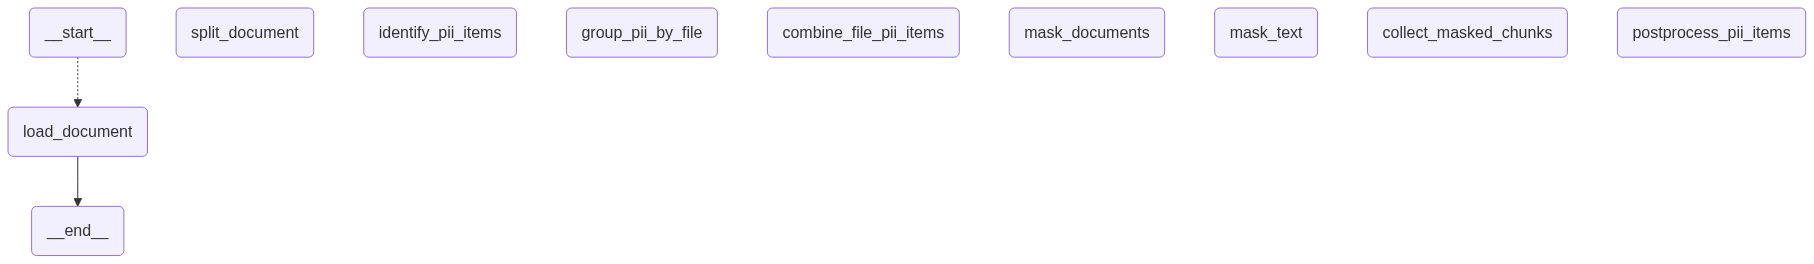

In [30]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
last_step = None
async for step in app.astream(
    {'files': 'documents'},
    {"recursion_limit": 25},
):
    print(list(step.keys()))
    last_step = step

In [ ]:
last_step['postprocess_pii_items']['final_pii_items']